# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
!pip install jupyter_contrib_nbextensions

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import imageio as imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(20)

In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

Reading folder names for training and validation. and setting the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
#train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
#val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 10

In [8]:
project_folder = '/home/datasets/Project_data'
project_folder_init = '/home/datasets/Project_data/model_init'

## Plotting

In [9]:
def plot(history, title):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[0].grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
    axes[0].minorticks_on()
    axes[0].grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)
    axes[0].set_title(title)

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    axes[1].grid(b=True, color='aqua', alpha=0.6, linestyle='dashdot')

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
class ModelBuilder(metaclass = abc.ABCMeta):
    
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self, image_height = 100, image_width = 100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
          
    def initialize_hyperparams(self, frames_to_sample = 30, batch_size = 20, num_epochs = 20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        
    def generator(self, source_path, folder_list, augment = False):
        img_idx = np.round(np.linspace(0, self.total_frames-1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels = self.one_batch_data(source_path, t,batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels 

            remaining_seq = len(t) % batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq = 0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_len, self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx, item in enumerate(img_idx): 
                image = imread.imread(source_path + '/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized = cv2.resize(image, (self.image_height, self.image_width))
            

                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped = shifted[x0:x1, y0:y1, :]
                    
                    image_resized = cv2.resize(cropped, (self.image_height, self.image_width))
                    
                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        
        return(batch_data, batch_labels)
    
    
    def train_model(self, model, augment_data = False):
        train_generator = self.generator(self.train_path, self.train_doc, augment = augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = os.path.join("model_init",'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/')
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 1, save_best_only = False, save_weights_only = False, mode = 'auto', period = 1)
        LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history = model.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = self.num_epochs, verbose = 1, 
                            callbacks = callbacks_list, validation_data = val_generator, 
                            validation_steps = validation_steps, class_weight = None, workers = 1, initial_epoch = 0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [11]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding ='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model


In [11]:
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 30, batch_size = 40, num_epochs = 1)
conv_3d1_model = conv_3d1.define_model()
conv_3d1_model.summary()

2022-11-10 09:19:51.496291: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-10 09:19:51.496353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

## Sample Cropping

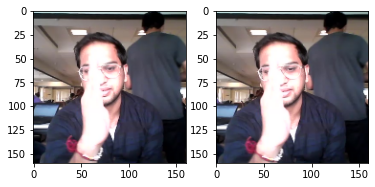

In [12]:
test_generator = ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height = 160, image_width = 160)
test_generator.initialize_hyperparams(frames_to_sample = 30, batch_size = 3, num_epochs = 1)

g=test_generator.generator(test_generator.val_path, test_generator.val_doc, augment = True)
batch_data, batch_labels = next(g)
fig, axes = plt.subplots(nrows = 1, ncols = 2)
axes[0].imshow(batch_data[0, 15, :, :, :])   
axes[1].imshow(batch_data[3, 15, :, :, :])  

## Experimenting with Image resolution, number of frames to use and batch_size

## 3D Convs Train Model 1 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 30, batch_size = 3, num_epochs = 1

In [13]:
%%time
conv_3d1.train_model(conv_3d1_model)

2022-11-10 09:19:59.316875: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.4960 - categorical_accuracy: 0.4374
Epoch 00001: saving model to model_init/model_init_2022-11-1009_19_52.686053/model-00001-1.49596-0.43741-2.05414-0.16000.h5
17/17 [==============================] - 75s 4s/step - loss: 1.4960 - categorical_accuracy: 0.4374 - val_loss: 2.0541 - val_categorical_accuracy: 0.1600 - lr: 0.0010
CPU times: user 1min 22s, sys: 15 s, total: 1min 37s
Wall time: 1min 19s


In [14]:
print("Memory utilization is {} GBs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory utilization is 3.662109524011612 GBs


## Following are the examples to see how training time is affected by image resolution, number of images in sequence and batch size

## 3D Convs Train Model 2 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 16, batch_size = 30, num_epochs = 3

In [15]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 30, num_epochs = 3)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.5167 - categorical_accuracy: 0.4540
Epoch 00001: saving model to model_init/model_init_2022-11-1009_21_12.164572/model-00001-1.51672-0.45400-2.75518-0.16000.h5
23/23 [==============================] - 40s 2s/step - loss: 1.5167 - categorical_accuracy: 0.4540 - val_loss: 2.7552 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 0.8822 - categorical_accuracy: 0.6637
Epoch 00002: saving model to model_init/model_init_2022-11-1009_21_12.164572/model-00002-0.88221-0.66365-3.40138-0.19000.h5
23/23 [==============================] - 38s 2s/step - loss: 0.8822 - categorical_accuracy: 0.6637 - val_loss: 3.4014 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/3
22/23 [===========================>..] - ETA: 1s - loss: 0.6670 - categorical_accuracy: 0.7333
Epoch 00003: saving model to model_init/model_init_2022-11-1009_21_12.164572/model-

## 3D Convs Train Model 3 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 30, batch_size = 30, num_epochs = 2

In [11]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 30, batch_size = 30, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813


2022-11-10 10:44:54.305973: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-10 10:44:54.306053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Epoch 1/2


2022-11-10 10:44:58.780996: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.5294 - categorical_accuracy: 0.4284
Epoch 00001: saving model to model_init/model_init_2022-11-1010_44_54.449417/model-00001-1.52937-0.42836-2.39746-0.16000.h5
23/23 [==============================] - 61s 3s/step - loss: 1.5294 - categorical_accuracy: 0.4284 - val_loss: 2.3975 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 0.9387 - categorical_accuracy: 0.6425
Epoch 00002: saving model to model_init/model_init_2022-11-1010_44_54.449417/model-00002-0.93871-0.64253-3.68949-0.16000.h5
23/23 [==============================] - 60s 3s/step - loss: 0.9387 - categorical_accuracy: 0.6425 - val_loss: 3.6895 - val_categorical_accuracy: 0.1600 - lr: 0.0010
CPU times: user 2min 4s, sys: 14 s, total: 2min 18s
Wall time: 2min 4s


## 3D Convs Train Model 4 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 30, batch_size = 60, num_epochs = 2

In [17]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 30, batch_size = 60, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.6678 - categorical_accuracy: 0.3831
Epoch 00001: saving model to model_init/model_init_2022-11-1009_23_10.247130/model-00001-1.66778-0.38311-1.56849-0.29000.h5
12/12 [==============================] - 61s 5s/step - loss: 1.6678 - categorical_accuracy: 0.3831 - val_loss: 1.5685 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/2
11/12 [==========================>...] - ETA: 4s - loss: 1.0567 - categorical_accuracy: 0.5970
Epoch 00002: saving model to model_init/model_init_2022-11-1009_23_10.247130/model-00002-1.05787-0.59729-2.19101-0.20000.h5
12/12 [==============================] - 57s 5s/step - loss: 1.0579 - categorical_accuracy: 0.5973 - val_loss: 2.1910 - val_categorical_accuracy: 0.2000 - lr: 0.0010
CPU times: user 2min 6s, sys: 13.2 s, total: 2min 20s
Wall time: 2min 2s


## 3D Convs Train Model 5 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 16, batch_size = 60, num_epochs = 2

In [18]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 60, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.7696 - categorical_accuracy: 0.3876
Epoch 00001: saving model to model_init/model_init_2022-11-1009_25_12.629058/model-00001-1.76959-0.38763-1.99296-0.16000.h5
12/12 [==============================] - 33s 3s/step - loss: 1.7696 - categorical_accuracy: 0.3876 - val_loss: 1.9930 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
11/12 [==========================>...] - ETA: 2s - loss: 1.0762 - categorical_accuracy: 0.5803
Epoch 00002: saving model to model_init/model_init_2022-11-1009_25_12.629058/model-00002-1.07760-0.57919-3.01312-0.15000.h5
12/12 [==============================] - 31s 3s/step - loss: 1.0776 - categorical_accuracy: 0.5792 - val_loss: 3.0131 - val_categorical_accuracy: 0.1500 - lr: 0.0010
CPU times: user 1min 8s, sys: 7.07 s, total: 1min 15s
Wall time: 1min 6s


## 3D Convs Train Model 6 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 16, batch_size = 80, num_epochs = 2

In [19]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 80, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 1.7008 - categorical_accuracy: 0.3514
Epoch 00001: saving model to model_init/model_init_2022-11-1009_26_19.604128/model-00001-1.70082-0.35143-1.55206-0.26000.h5
9/9 [==============================] - 34s 4s/step - loss: 1.7008 - categorical_accuracy: 0.3514 - val_loss: 1.5521 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 1.1003 - categorical_accuracy: 0.5943
Epoch 00002: saving model to model_init/model_init_2022-11-1009_26_19.604128/model-00002-1.10025-0.59427-2.00372-0.25000.h5
9/9 [==============================] - 29s 4s/step - loss: 1.1003 - categorical_accuracy: 0.5943 - val_loss: 2.0037 - val_categorical_accuracy: 0.2500 - lr: 0.0010
CPU times: user 1min 9s, sys: 7.35 s, total: 1min 16s
Wall time: 1min 6s


## 3D Convs Train Model 7 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 30, batch_size = 15, num_epochs = 2

In [20]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 30, batch_size = 15, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6634 - categorical_accuracy: 0.3952
Epoch 00001: saving model to model_init/model_init_2022-11-1009_27_25.731719/model-00001-1.66343-0.39517-2.05448-0.22000.h5
45/45 [==============================] - 72s 2s/step - loss: 1.6634 - categorical_accuracy: 0.3952 - val_loss: 2.0545 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.1116 - categorical_accuracy: 0.5566
Epoch 00002: saving model to model_init/model_init_2022-11-1009_27_25.731719/model-00002-1.11165-0.55656-2.03063-0.22000.h5
45/45 [==============================] - 70s 2s/step - loss: 1.1116 - categorical_accuracy: 0.5566 - val_loss: 2.0306 - val_categorical_accuracy: 0.2200 - lr: 0.0010
CPU times: user 2min 21s, sys: 25.7 s, total: 2min 47s
Wall time: 2min 24s


## 3D Convs Train Model 8 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 16, batch_size = 15, num_epochs = 2

In [21]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 15,num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.4595 - categorical_accuracy: 0.4555
Epoch 00001: saving model to model_init/model_init_2022-11-1009_29_49.900882/model-00001-1.45945-0.45551-6.58532-0.14000.h5
45/45 [==============================] - 40s 861ms/step - loss: 1.4595 - categorical_accuracy: 0.4555 - val_loss: 6.5853 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.9754 - categorical_accuracy: 0.6109
Epoch 00002: saving model to model_init/model_init_2022-11-1009_29_49.900882/model-00002-0.97538-0.61086-10.11924-0.16000.h5
45/45 [==============================] - 39s 878ms/step - loss: 0.9754 - categorical_accuracy: 0.6109 - val_loss: 10.1192 - val_categorical_accuracy: 0.1600 - lr: 0.0010
CPU times: user 1min 17s, sys: 14.7 s, total: 1min 32s
Wall time: 1min 19s


## 3D Convs Train Model 9 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 16, batch_size = 15, num_epochs = 2

In [22]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 15, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
44/45 [============================>.] - ETA: 0s - loss: 1.6225 - categorical_accuracy: 0.4000
Epoch 00001: saving model to model_init/model_init_2022-11-1009_31_09.239425/model-00001-1.62218-0.39970-6.87436-0.16000.h5
45/45 [==============================] - 33s 712ms/step - loss: 1.6222 - categorical_accuracy: 0.3997 - val_loss: 6.8744 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0120 - categorical_accuracy: 0.6561
Epoch 00002: saving model to model_init/model_init_2022-11-1009_31_09.239425/model-00002-1.01196-0.65611-11.19097-0.14000.h5
45/45 [==============================] - 32s 716ms/step - loss: 1.0120 - categorical_accuracy: 0.6561 - val_loss: 11.1910 - val_categorical_accuracy: 0.1400 - lr: 0.0010
CPU times: user 1min 6s, sys: 4.55 s, total: 1min 11s
Wall time: 1min 5s


## 3D Convs Train Model 10 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 16, batch_size = 10, num_epochs = 2

In [23]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 10, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6417 - categorical_accuracy: 0.3680
Epoch 00001: saving model to model_init/model_init_2022-11-1009_32_14.294432/model-00001-1.64171-0.36802-4.78494-0.16000.h5
67/67 [==============================] - 33s 481ms/step - loss: 1.6417 - categorical_accuracy: 0.3680 - val_loss: 4.7849 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1685 - categorical_accuracy: 0.5234
Epoch 00002: saving model to model_init/model_init_2022-11-1009_32_14.294432/model-00002-1.16853-0.52338-6.04207-0.14000.h5
67/67 [==============================] - 31s 475ms/step - loss: 1.1685 - categorical_accuracy: 0.5234 - val_loss: 6.0421 - val_categorical_accuracy: 0.1400 - lr: 0.0010
CPU times: user 1min 7s, sys: 4.1 s, total: 1min 11s
Wall time: 1min 4s


## 3D Convs Train Model 11 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 30, batch_size = 10, num_epochs = 2

In [24]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 30, batch_size = 10, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6026 - categorical_accuracy: 0.3906
Epoch 00001: saving model to model_init/model_init_2022-11-1009_33_19.221240/model-00001-1.60256-0.39065-3.24840-0.16000.h5
67/67 [==============================] - 61s 898ms/step - loss: 1.6026 - categorical_accuracy: 0.3906 - val_loss: 3.2484 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1336 - categorical_accuracy: 0.5339
Epoch 00002: saving model to model_init/model_init_2022-11-1009_33_19.221240/model-00002-1.13360-0.53394-3.73238-0.18000.h5
67/67 [==============================] - 58s 883ms/step - loss: 1.1336 - categorical_accuracy: 0.5339 - val_loss: 3.7324 - val_categorical_accuracy: 0.1800 - lr: 0.0010
CPU times: user 2min, sys: 11.2 s, total: 2min 11s
Wall time: 2min


## 3D Convs Train Model 12 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 30, batch_size = 10, num_epochs = 2

In [25]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 30, batch_size = 10, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.5643 - categorical_accuracy: 0.4434
Epoch 00001: saving model to model_init/model_init_2022-11-1009_35_19.824580/model-00001-1.56427-0.44344-8.81895-0.21000.h5
67/67 [==============================] - 78s 1s/step - loss: 1.5643 - categorical_accuracy: 0.4434 - val_loss: 8.8190 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1308 - categorical_accuracy: 0.5581
Epoch 00002: saving model to model_init/model_init_2022-11-1009_35_19.824580/model-00002-1.13082-0.55807-7.10535-0.12000.h5
67/67 [==============================] - 74s 1s/step - loss: 1.1308 - categorical_accuracy: 0.5581 - val_loss: 7.1054 - val_categorical_accuracy: 0.1200 - lr: 0.0010
CPU times: user 2min 21s, sys: 34.7 s, total: 2min 55s
Wall time: 2min 33s


## 3D Convs Train Model 13 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 16, batch_size = 10, num_epochs = 2

In [26]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 10, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.4409 - categorical_accuracy: 0.4389
Epoch 00001: saving model to model_init/model_init_2022-11-1009_37_52.977916/model-00001-1.44095-0.43891-12.36989-0.21000.h5
67/67 [==============================] - 43s 622ms/step - loss: 1.4409 - categorical_accuracy: 0.4389 - val_loss: 12.3699 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.0602 - categorical_accuracy: 0.5928
Epoch 00002: saving model to model_init/model_init_2022-11-1009_37_52.977916/model-00002-1.06017-0.59276-11.42044-0.21000.h5
67/67 [==============================] - 40s 612ms/step - loss: 1.0602 - categorical_accuracy: 0.5928 - val_loss: 11.4204 - val_categorical_accuracy: 0.2100 - lr: 0.0010
CPU times: user 1min 19s, sys: 17.8 s, total: 1min 37s
Wall time: 1min 23s


## 3D Convs Train Model 14 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 16, batch_size = 40, num_epochs = 2

In [27]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 40, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.5579 - categorical_accuracy: 0.4042
Epoch 00001: saving model to model_init/model_init_2022-11-1009_39_16.762777/model-00001-1.55789-0.40422-1.74103-0.20000.h5
17/17 [==============================] - 45s 3s/step - loss: 1.5579 - categorical_accuracy: 0.4042 - val_loss: 1.7410 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 0.9977 - categorical_accuracy: 0.6109
Epoch 00002: saving model to model_init/model_init_2022-11-1009_39_16.762777/model-00002-0.99769-0.61086-5.80402-0.25000.h5
17/17 [==============================] - 43s 3s/step - loss: 0.9977 - categorical_accuracy: 0.6109 - val_loss: 5.8040 - val_categorical_accuracy: 0.2500 - lr: 0.0010
CPU times: user 1min 21s, sys: 22.4 s, total: 1min 44s
Wall time: 1min 29s


| **3D_CNN Model** | **Image Height** | **Image Width** | **Frame** | **batch** | **epochs** | **Parameters** | **Training Time** |
|---|---|---|---|---|---|---|---|
| **3D_CNN_1** | 160 | 160 | 30 | 3 | 1 | 1736389 | 1min 41s |
| **3D_CNN_2** | 160 | 160 | 16 | 30 | 3 | 1736389 | 2min 18s |
| **3D_CNN_3** | 100 | 100 | 30 | 30 | 2 | 687813 | 2min 14s |
| **3D_CNN_4** | 100 | 100 | 30 | 60 | 2 | 687813 | 2min 19s |
| **3D_CNN_5** | 100 | 100 | 16 | 60 | 2 | 687813 | 1mn 16s |
| **3D_CNN_6** | 100 | 100 | 16 | 80 | 2 | 687813 | 1min 18s |
| **3D_CNN_7** | 160 | 160 | 30 | 15 | 2 | 1736389 | 2min 46s |
| **3D_CNN_8** | 160 | 160 | 16 | 15 | 2 | 1736389 | 1min 31s |
| **3D_CNN_9** | 100 | 100 | 16 | 15 | 2 | 687813 | 1min 10s |
| **3D_CNN_10** | 100 | 100 | 16 | 10 | 2 | 687813 | 1min 10s |
| **3D_CNN_11** | 100 | 100 | 30 | 10 | 2 | 687813 | 2min 10s |
| **3D_CNN_12** | 160 | 160 | 30 | 10 | 2 | 1736389 | 2min 46s |
| **3D_CNN_13** | 160 | 160 | 16 | 10 | 2 | 1736389 | 1min 33s |
| **3D_CNN_14** | 160 | 160 | 16 | 40 | 2 | 1736389 | 1min 34s |

As per above experiments image resolution and number of frames in sequence have more impact on training time than batch_size.
So experimentations will be carried out with batch size fixed between 15-40 and changing the resolution and number of image per sequence based on the device memory constraints.

### Model 1 - Base Model with No Augmentation Batch Size 40 and Epoch 15

In [28]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self, filtersize = (3, 3, 3), dense_neurons = 64, dropout = 0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding = 'same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [29]:
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 20, batch_size = 40, num_epochs = 15)
conv_3d1_model = conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_78 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_52 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_53 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_53 (Activation)  (None, 10, 80, 80, 32)  

In [30]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5962 - categorical_accuracy: 0.4238
Epoch 00001: saving model to model_init/model_init_2022-11-1009_40_46.763995/model-00001-1.59619-0.42383-1.95494-0.17000.h5
17/17 [==============================] - 55s 3s/step - loss: 1.5962 - categorical_accuracy: 0.4238 - val_loss: 1.9549 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.9232 - categorical_accuracy: 0.6275
Epoch 00002: saving model to model_init/model_init_2022-11-1009_40_46.763995/model-00002-0.92320-0.62745-2.59508-0.23000.h5
17/17 [==============================] - 52s 3s/step - loss: 0.9232 - categorical_accuracy: 0.6275 - val_loss: 2.5951 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.6862 - categorical_accuracy: 0.7195
Epoch 00003: saving model to model_init/model_init_2022-11-1009_40_46.763995/mod

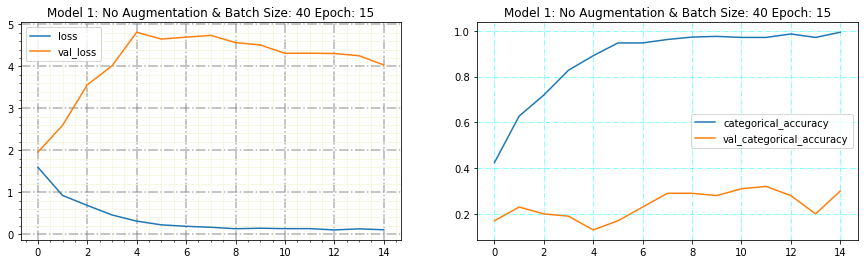

In [31]:
plot(history_model1,'Model 1: No Augmentation & Batch Size: 40 Epoch: 15')

Model is overfitting as Validation is greater than training and accuracy is less than training. So, adding augment data

### Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [32]:
conv_3d2 = ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d2.initialize_hyperparams(frames_to_sample = 20, batch_size = 20, num_epochs = 25)
conv_3d2_model = conv_3d2.define_model(dense_neurons = 256, dropout = 0.5)
conv_3d2_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_56 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_84 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_57 (Activation)  (None, 10, 80, 80, 32)  

In [33]:
print("Total Params:", conv_3d2_model.count_params())
history_model2 = conv_3d2.train_model(conv_3d2_model, augment_data = True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9581 - categorical_accuracy: 0.3891
Epoch 00001: saving model to model_init/model_init_2022-11-1009_53_17.067534/model-00001-1.95807-0.38914-2.41206-0.18000.h5
34/34 [==============================] - 99s 3s/step - loss: 1.9581 - categorical_accuracy: 0.3891 - val_loss: 2.4121 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3207 - categorical_accuracy: 0.5445
Epoch 00002: saving model to model_init/model_init_2022-11-1009_53_17.067534/model-00002-1.32075-0.54449-4.16057-0.24000.h5
34/34 [==============================] - 99s 3s/step - loss: 1.3207 - categorical_accuracy: 0.5445 - val_loss: 4.1606 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1205 - categorical_accuracy: 0.6116
Epoch 00003: saving model to model_init/model_init_2022-11-1009_53_17.067534/mod

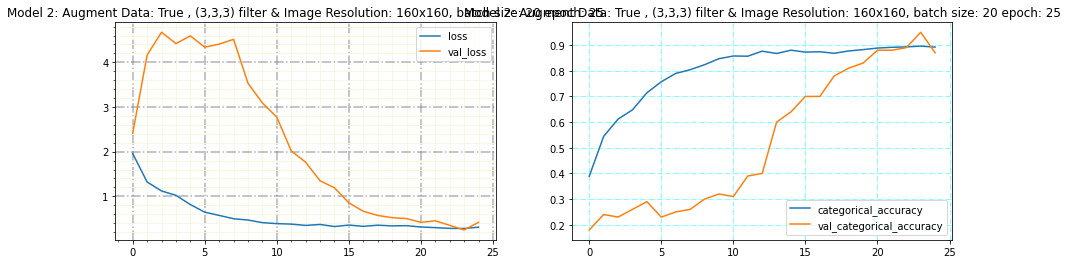

In [34]:
plot(history_model2,'Model 2: Augment Data: True , (3,3,3) filter & Image Resolution: 160x160, batch size: 20 epoch: 25')

Model is not overfitting as we get validation accuracy of 87% and training accuracy of 89%. 
Next we can try to reduce the filter size and image resolution and check if better results come. As we see minor oscillations in categorical accuracy, let's try lowering the learning rate to 0.0002

### Model 3 - Reduce filter size to (2,2,2) and image res to 120 x 120

In [12]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        #adding learning rate
        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height = 120, image_width = 120)
conv_3d3.initialize_hyperparams(frames_to_sample = 16, batch_size = 30, num_epochs = 30)
conv_3d3_model = conv_3d3.define_model(filtersize=(2,2,2), dense_neurons = 256, dropout = 0.5)
conv_3d3_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  400       
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)    

In [14]:
print("Total Params:", conv_3d3_model.count_params())
history_model3 = conv_3d3.train_model(conv_3d3_model, augment_data = True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.9204 - categorical_accuracy: 0.3846
Epoch 00001: saving model to model_init/model_init_2022-11-1010_48_10.777973/model-00001-1.92037-0.38462-1.98212-0.16000.h5
23/23 [==============================] - 63s 3s/step - loss: 1.9204 - categorical_accuracy: 0.3846 - val_loss: 1.9821 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.4732 - categorical_accuracy: 0.4977
Epoch 00002: saving model to model_init/model_init_2022-11-1010_48_10.777973/model-00002-1.47320-0.49774-3.15260-0.18000.h5
23/23 [==============================] - 61s 3s/step - loss: 1.4732 - categorical_accuracy: 0.4977 - val_loss: 3.1526 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.1856 - categorical_accuracy: 0.5890
Epoch 00003: saving model to model_init/model_init_2022-11-1010_48_10.77

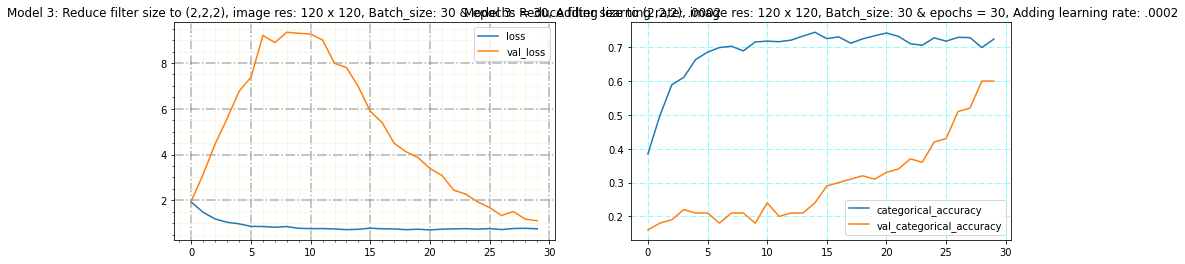

In [15]:
plot(history_model3, "Model 3: Reduce filter size to (2,2,2), image res: 120 x 120, Batch_size: 30 & epochs = 30, Adding learning rate: .0002")

This model clearly shows overfitting

### Model 4 - Adding more layers

In [16]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize = (3, 3, 3), dense_neurons = 64, dropout = 0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding = 'same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics= ['categorical_accuracy'])
        return model

In [17]:
conv_3d4 = ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height = 120, image_width = 120)
conv_3d4.initialize_hyperparams(frames_to_sample = 16, batch_size = 20, num_epochs = 30)
conv_3d4_model=conv_3d4.define_model(filtersize = (3, 3, 3), dense_neurons = 256, dropout = 0.5)
conv_3d4_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_9 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_9 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_13 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [18]:
print("Total Params:", conv_3d4_model.count_params())
history_model4 = conv_3d4.train_model(conv_3d4_model, augment_data = True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8907 - categorical_accuracy: 0.3906
Epoch 00001: saving model to model_init/model_init_2022-11-1011_18_16.422832/model-00001-1.89067-0.39065-5.37227-0.25000.h5
34/34 [==============================] - 68s 2s/step - loss: 1.8907 - categorical_accuracy: 0.3906 - val_loss: 5.3723 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5272 - categorical_accuracy: 0.4819
Epoch 00002: saving model to model_init/model_init_2022-11-1011_18_16.422832/model-00002-1.52722-0.48190-1.78827-0.34000.h5
34/34 [==============================] - 62s 2s/step - loss: 1.5272 - categorical_accuracy: 0.4819 - val_loss: 1.7883 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.4602 - categorical_accuracy: 0.4992
Epoch 00003: saving model to model_init/model_init_2022-11-1011_18_16.422832/mod

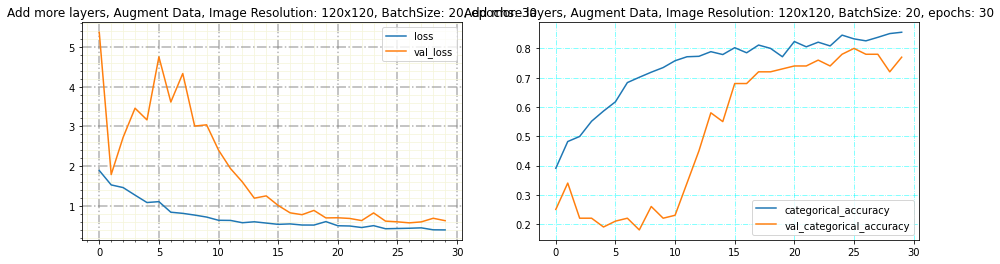

In [19]:
plot(history_model4, "Add more layers, Augment Data, Image Resolution: 120x120, BatchSize: 20, epochs: 30")

In this Model with more layers, cant observe much improvement in acuracy i.e 77% 

### Model 5: Adding dropout at convolution layers

In [20]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self, filtersize = (3, 3, 3), dense_neurons = 64, dropout = 0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding = 'same',
                 input_shape = (self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding = 'same',
                 input_shape = (self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [21]:
conv_3d5 = ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height = 120, image_width = 120)
conv_3d5.initialize_hyperparams(frames_to_sample = 16, batch_size = 20, num_epochs = 22)
conv_3d5_model=conv_3d5.define_model(filtersize = (3,3,3), dense_neurons = 256, dropout = 0.25)
conv_3d5_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_22 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_17 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_17 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_23 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [22]:
print("Total Params:", conv_3d5_model.count_params())
history_model5 = conv_3d5.train_model(conv_3d5_model, augment_data = True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - ETA: 0s - loss: 1.7949 - categorical_accuracy: 0.3680
Epoch 00001: saving model to model_init/model_init_2022-11-1011_49_27.922659/model-00001-1.79493-0.36802-3.81653-0.16000.h5
34/34 [==============================] - 64s 2s/step - loss: 1.7949 - categorical_accuracy: 0.3680 - val_loss: 3.8165 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/22
34/34 [==============================] - ETA: 0s - loss: 1.3436 - categorical_accuracy: 0.4796
Epoch 00002: saving model to model_init/model_init_2022-11-1011_49_27.922659/model-00002-1.34365-0.47964-4.90001-0.22000.h5
34/34 [==============================] - 62s 2s/step - loss: 1.3436 - categorical_accuracy: 0.4796 - val_loss: 4.9000 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/22
34/34 [==============================] - ETA: 0s - loss: 1.0256 - categorical_accuracy: 0.6176
Epoch 00003: saving model to model_init/model_init_2022-11-1011_49_27.922659/mod

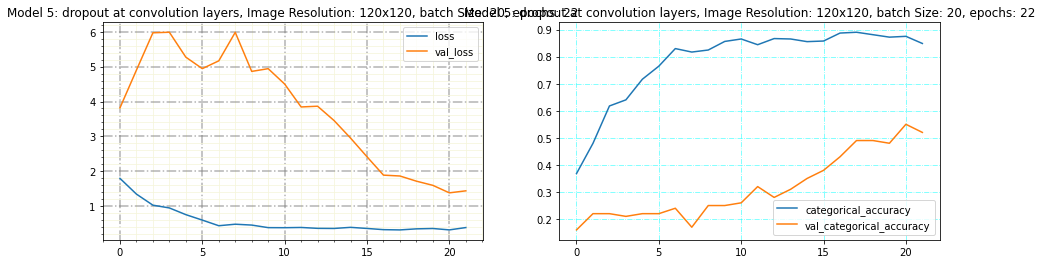

In [23]:
plot(history_model5,"Model 5: dropout at convolution layers, Image Resolution: 120x120, batch Size: 20, epochs: 22")

Validation accuracy is further dropped after adding dropouts. as its not to learn generalizable features
Let's try to reduce the model size and see the performance

### Model 6 - Number of parameters to be Decrease

In [27]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self, dense_neurons = 64, dropout = 0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding = 'same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam(lr = 0.0002)
        model.compile(optimizer = optimiser, loss= 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [28]:
conv_3d6 = ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d6.initialize_hyperparams(frames_to_sample = 16, batch_size = 20, num_epochs = 30)
conv_3d6_model = conv_3d6.define_model(dense_neurons = 128, dropout = 0.25)
conv_3d6_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_38 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_29 (Activation)  (None, 8, 50, 50, 32)    

In [29]:
print("Total Params:", conv_3d6_model.count_params())
history_model6 = conv_3d6.train_model(conv_3d6_model, augment_data = True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8283 - categorical_accuracy: 0.3416
Epoch 00001: saving model to model_init/model_init_2022-11-1012_16_49.740736/model-00001-1.82827-0.34163-1.98894-0.16000.h5
34/34 [==============================] - 63s 2s/step - loss: 1.8283 - categorical_accuracy: 0.3416 - val_loss: 1.9889 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2016 - categorical_accuracy: 0.5234
Epoch 00002: saving model to model_init/model_init_2022-11-1012_16_49.740736/model-00002-1.20155-0.52338-3.32454-0.13000.h5
34/34 [==============================] - 58s 2s/step - loss: 1.2016 - categorical_accuracy: 0.5234 - val_loss: 3.3245 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.0455 - categorical_accuracy: 0.6154
Epoch 00003: saving model to model_init/model_init_2022-11-1012_16_49.740

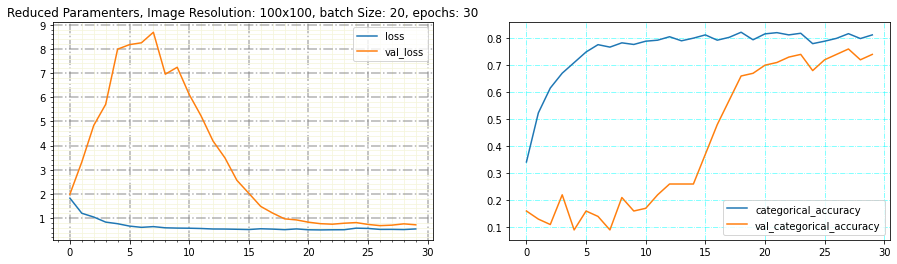

In [30]:
plot(history_model6, "Reduced Paramenters, Image Resolution: 100x100, batch Size: 20, epochs: 30")

Validation Accuracy: 74

### Model 7 - reducing the number of parameters (updated pool Size)

In [34]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding ='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam(lr = 0.0002)
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [35]:
conv_3d7 = ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height = 120, image_width = 120)
conv_3d7.initialize_hyperparams(frames_to_sample = 16, batch_size = 20, num_epochs = 25)
conv_3d7_model = conv_3d7.define_model(dense_neurons = 64, dropout = 0.25)
conv_3d7_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_40 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_56 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_41 (Activation)  (None, 8, 60, 60, 32)    

In [36]:
print("Total Params:", conv_3d7_model.count_params())
history_model7 = conv_3d7.train_model(conv_3d7_model, augment_data = True)

Total Params: 504709
Epoch 1/25
33/34 [============================>.] - ETA: 1s - loss: 1.8480 - categorical_accuracy: 0.3432
Epoch 00001: saving model to model_init/model_init_2022-11-1012_48_44.254377/model-00001-1.85205-0.34238-1.92844-0.21000.h5
34/34 [==============================] - 63s 2s/step - loss: 1.8521 - categorical_accuracy: 0.3424 - val_loss: 1.9284 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2763 - categorical_accuracy: 0.5113
Epoch 00002: saving model to model_init/model_init_2022-11-1012_48_44.254377/model-00002-1.27634-0.51131-2.76107-0.17000.h5
34/34 [==============================] - 62s 2s/step - loss: 1.2763 - categorical_accuracy: 0.5113 - val_loss: 2.7611 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/25
33/34 [============================>.] - ETA: 1s - loss: 1.0844 - categorical_accuracy: 0.5818
Epoch 00003: saving model to model_init/model_init_2022-11-1012_48_44.254

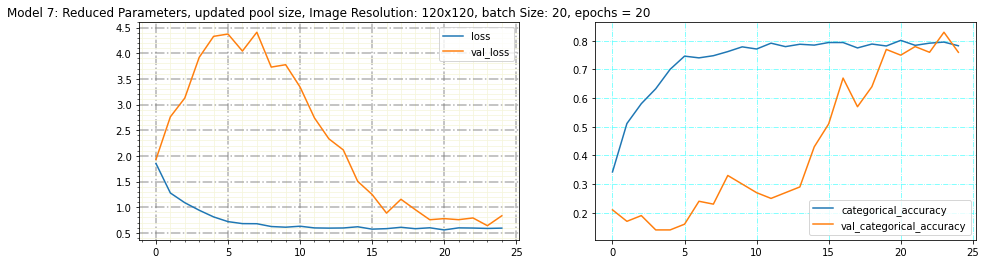

In [37]:
plot(history_model7, "Model 7: Reduced Parameters, updated pool size, Image Resolution: 120x120, batch Size: 20, epochs = 20")

Validation Accuracy: 76

### Model 8 - reducing the number of parameters

In [38]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self, dense_neurons = 64, dropout = 0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding = 'same',
                 input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam(lr = 0.0002)
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [39]:
conv_3d8 = ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height = 120, image_width = 120)
conv_3d8.initialize_hyperparams(frames_to_sample = 16, batch_size = 20, num_epochs = 30)
conv_3d8_model = conv_3d8.define_model(dense_neurons = 64, dropout = 0.25)
conv_3d8_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_44 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_62 (Bat  (None, 16, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_45 (Activation)  (None, 8, 60, 60, 16)    

In [40]:
print("Total Params:", conv_3d8_model.count_params())
history_model8 = conv_3d8.train_model(conv_3d8_model, augment_data = True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.0451 - categorical_accuracy: 0.2511
Epoch 00001: saving model to model_init/model_init_2022-11-1013_14_55.843872/model-00001-2.04510-0.25113-1.68212-0.16000.h5
34/34 [==============================] - 66s 2s/step - loss: 2.0451 - categorical_accuracy: 0.2511 - val_loss: 1.6821 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5866 - categorical_accuracy: 0.3816
Epoch 00002: saving model to model_init/model_init_2022-11-1013_14_55.843872/model-00002-1.58658-0.38160-1.84386-0.15000.h5
34/34 [==============================] - 63s 2s/step - loss: 1.5866 - categorical_accuracy: 0.3816 - val_loss: 1.8439 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3753 - categorical_accuracy: 0.4676
Epoch 00003: saving model to model_init/model_init_2022-11-1013_14_55.843

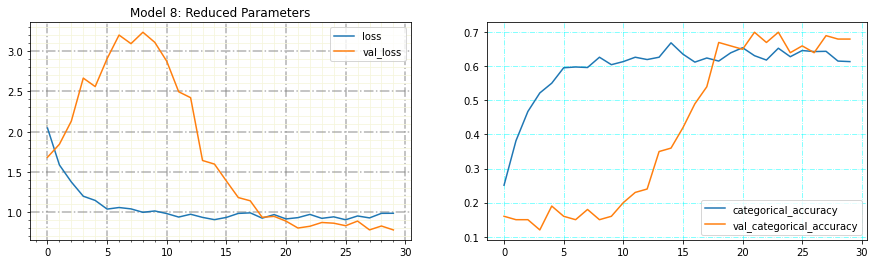

In [41]:
plot(history_model8, "Model 8: Reduced Parameters")

## Model 9 - CNN- LSTM Model

In [10]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self, lstm_cells = 64, dense_neurons = 64, dropout = 0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding = 'same', activation = 'relu'),
                                  input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding = 'same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding = 'same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding = 'same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding = 'same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation = 'softmax'))
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [43]:
rnn_cnn1 = RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height = 120, image_width = 120)
rnn_cnn1.initialize_hyperparams(frames_to_sample = 18, batch_size = 20, num_epochs = 20)
rnn_cnn1_model = rnn_cnn1.define_model(lstm_cells = 128, dense_neurons = 128, dropout = 0.25)
rnn_cnn1_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32) 

In [44]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9 = rnn_cnn1.train_model(rnn_cnn1_model, augment_data = True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3921 - categorical_accuracy: 0.4216
Epoch 00001: saving model to model_init/model_init_2022-11-1013_46_03.419672/model-00001-1.39205-0.42157-1.96368-0.21000.h5
34/34 [==============================] - 73s 2s/step - loss: 1.3921 - categorical_accuracy: 0.4216 - val_loss: 1.9637 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0868 - categorical_accuracy: 0.5830
Epoch 00002: saving model to model_init/model_init_2022-11-1013_46_03.419672/model-00002-1.08676-0.58296-3.07652-0.19000.h5
34/34 [==============================] - 69s 2s/step - loss: 1.0868 - categorical_accuracy: 0.5830 - val_loss: 3.0765 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9142 - categorical_accuracy: 0.6275
Epoch 00003: saving model to model_init/model_init_2022-11-1013_46_03.419672/mod

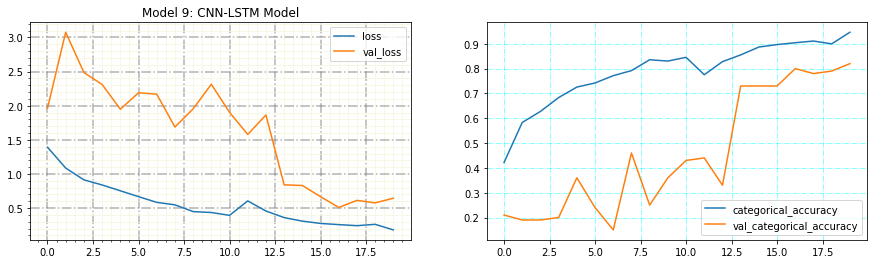

In [45]:
plot(history_model9, "Model 9: CNN-LSTM Model")

### Adding Augmentation

In [15]:
class ModelBuilderMoreAugmentation(metaclass = abc.ABCMeta):
    
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self, image_height = 100, image_width = 100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
          
    def initialize_hyperparams(self, frames_to_sample = 30, batch_size = 20, num_epochs = 20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        
    def generator(self, source_path, folder_list, augment = False):
        img_idx = np.round(np.linspace(0, self.total_frames-1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels 

            remaining_seq = len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq = 0):
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_len, self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized = cv2.resize(image,(self.image_height,self.image_width))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped = shifted[x0:x1,y0:y1,:]
                    
                    image_resized = cv2.resize(cropped,(self.image_height,self.image_width))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        if (augment):
            batch_data = np.concatenate([batch_data,batch_data_aug])
            batch_labels = np.concatenate([batch_labels,batch_labels])

        
        return(batch_data, batch_labels)
    
    
    def train_model(self, model, augment_data = False):
        train_generator = self.generator(self.train_path, self.train_doc, augment = augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = os.path.join("model_init",'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/')
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 1, save_best_only = False, save_weights_only = False, mode = 'auto', period = 1)
        LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Re-running model after adding more Augmentation

### Model 10 - filter: 3,3,3, Image Reso: 160x160

In [16]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize = (3, 3, 3), dense_neurons = 64, dropout = 0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding = 'same',
                 input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam(lr = 0.0002)
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [13]:
conv_3d10 = ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d10.initialize_hyperparams(frames_to_sample = 20, batch_size = 20, num_epochs = 30)
conv_3d10_model = conv_3d10.define_model(dense_neurons = 256, dropout = 0.5)
conv_3d10_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)    0

2022-11-10 15:14:09.354013: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-10 15:14:09.354087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [14]:
print("Total Params:", conv_3d10_model.count_params())
history_model10 = conv_3d10.train_model(conv_3d10_model, augment_data=True)

Total Params: 3638981
Epoch 1/30


2022-11-10 15:14:51.391887: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.9518 - categorical_accuracy: 0.3891
Epoch 00001: saving model to model_init/model_init_2022-11-1015_14_45.984113/model-00001-1.95175-0.38914-2.87421-0.22000.h5
34/34 [==============================] - 100s 3s/step - loss: 1.9518 - categorical_accuracy: 0.3891 - val_loss: 2.8742 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.3640 - categorical_accuracy: 0.5309
Epoch 00002: saving model to model_init/model_init_2022-11-1015_14_45.984113/model-00002-1.36404-0.53092-5.02728-0.16000.h5
34/34 [==============================] - 97s 3s/step - loss: 1.3640 - categorical_accuracy: 0.5309 - val_loss: 5.0273 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.0327 - categorical_accuracy: 0.6305
Epoch 00003: saving model to model_init/model_init_2022-11-1015_14_45.984113/model-00003-1.03272-0.63047

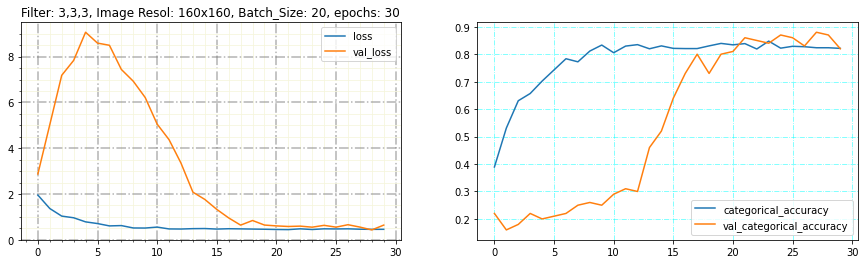

In [15]:
plot(history_model10,"Filter: 3,3,3, Image Resol: 160x160, Batch_Size: 20, epochs: 30")

### Model 11 - filter: (2,2,2), Image resolution: 120x120

In [16]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self, filtersize = (3, 3, 3), dense_neurons = 64, dropout = 0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding = 'same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam(lr = 0.0002)
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [17]:
conv_3d11 = ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height = 120, image_width = 120)
conv_3d11.initialize_hyperparams(frames_to_sample = 16, batch_size = 30, num_epochs = 30)
conv_3d11_model = conv_3d11.define_model(filtersize = (2,2,2), dense_neurons = 256, dropout = 0.5)
conv_3d11_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  400       
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)    

In [18]:
print("Total Params:", conv_3d11_model.count_params())
history_model11 = conv_3d11.train_model(conv_3d11_model, augment_data = True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.1277 - categorical_accuracy: 0.3499
Epoch 00001: saving model to model_init/model_init_2022-11-1016_03_07.258467/model-00001-2.12766-0.34992-1.79485-0.21000.h5
23/23 [==============================] - 67s 3s/step - loss: 2.1277 - categorical_accuracy: 0.3499 - val_loss: 1.7948 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5191 - categorical_accuracy: 0.5023
Epoch 00002: saving model to model_init/model_init_2022-11-1016_03_07.258467/model-00002-1.51909-0.50226-2.19456-0.23000.h5
23/23 [==============================] - 64s 3s/step - loss: 1.5191 - categorical_accuracy: 0.5023 - val_loss: 2.1946 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.2116 - categorical_accuracy: 0.5656
Epoch 00003: saving model to model_init/model_init_2022-11-1016_03_07.25

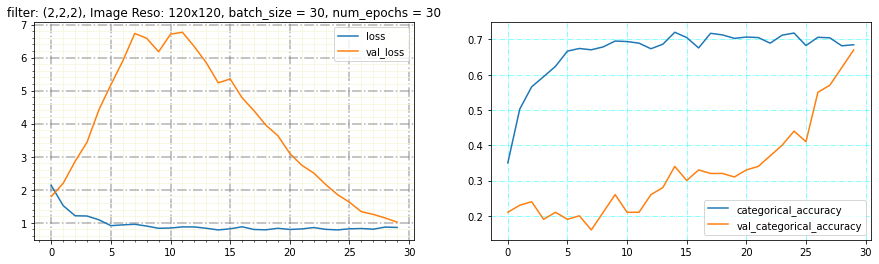

In [19]:
plot(history_model11, "filter: (2,2,2), Image Reso: 120x120, batch_size = 30, num_epochs = 30")

### Model 12 - Adding more layers

In [11]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize = (3, 3, 3), dense_neurons = 64, dropout = 0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding = 'same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding = 'same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam(lr = 0.0002)
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [12]:
conv_3d12 = ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height = 120, image_width = 120)
conv_3d12.initialize_hyperparams(frames_to_sample = 16, batch_size = 20, num_epochs = 30)
conv_3d12_model = conv_3d12.define_model(filtersize = (3,3,3), dense_neurons = 256, dropout = 0.5)
conv_3d12_model.summary()

2022-11-11 07:27:06.443674: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-11 07:27:06.443770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                        

In [13]:
print("Total Params:", conv_3d12_model.count_params())
history_model12 = conv_3d12.train_model(conv_3d12_model, augment_data = True)

Total Params: 2556533
Epoch 1/30


2022-11-11 07:27:28.435976: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 2.1659 - categorical_accuracy: 0.3115
Epoch 00001: saving model to model_init/model_init_2022-11-1107_27_23.532086/model-00001-2.16592-0.31146-2.00091-0.21000.h5
34/34 [==============================] - 80s 2s/step - loss: 2.1659 - categorical_accuracy: 0.3115 - val_loss: 2.0009 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5586 - categorical_accuracy: 0.4789
Epoch 00002: saving model to model_init/model_init_2022-11-1107_27_23.532086/model-00002-1.55863-0.47888-2.60172-0.27000.h5
34/34 [==============================] - 69s 2s/step - loss: 1.5586 - categorical_accuracy: 0.4789 - val_loss: 2.6017 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2112 - categorical_accuracy: 0.5656
Epoch 00003: saving model to model_init/model_init_2022-11-1107_27_23.532086/model-00003-1.21125-0.56561-

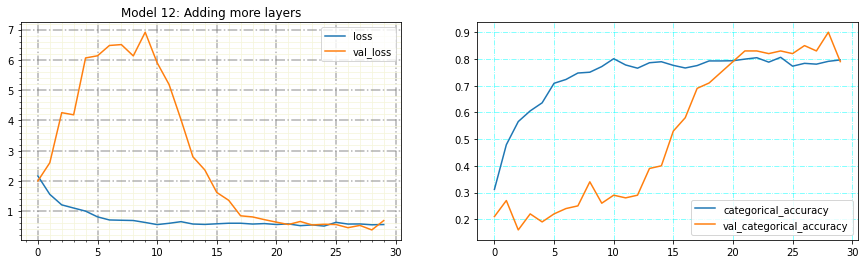

In [14]:
plot(history_model12, "Model 12: Adding more layers")

### Model 13 - Adding dropouts

In [15]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize = (3, 3, 3), dense_neurons = 64, dropout = 0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding = 'same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding = 'same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam(lr = 0.0002)
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [16]:
conv_3d13 = ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height = 120, image_width = 120)
conv_3d13.initialize_hyperparams(frames_to_sample = 16, batch_size = 20, num_epochs = 25)
conv_3d13_model = conv_3d13.define_model(filtersize = (3,3,3), dense_neurons = 256, dropout = 0.25)
conv_3d13_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_9 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_9 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_11 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [17]:
print("Total Params:", conv_3d13_model.count_params())
history_model13 = conv_3d13.train_model(conv_3d13_model, augment_data = True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9458 - categorical_accuracy: 0.3009
Epoch 00001: saving model to model_init/model_init_2022-11-1108_02_00.189731/model-00001-1.94584-0.30090-2.33843-0.21000.h5
34/34 [==============================] - 75s 2s/step - loss: 1.9458 - categorical_accuracy: 0.3009 - val_loss: 2.3384 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4792 - categorical_accuracy: 0.4593
Epoch 00002: saving model to model_init/model_init_2022-11-1108_02_00.189731/model-00002-1.47923-0.45928-3.32173-0.22000.h5
34/34 [==============================] - 70s 2s/step - loss: 1.4792 - categorical_accuracy: 0.4593 - val_loss: 3.3217 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3807 - categorical_accuracy: 0.5023
Epoch 00003: saving model to model_init/model_init_2022-11-1108_02_00.18

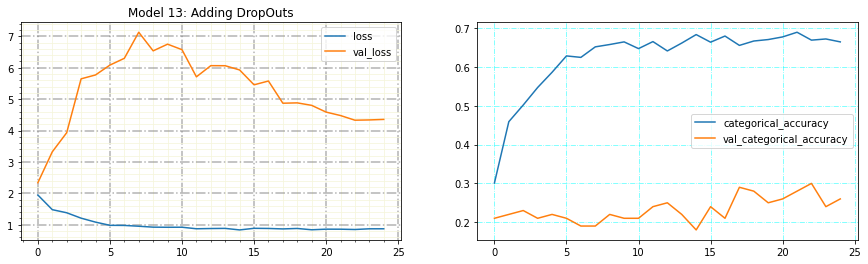

In [18]:
plot(history_model13, "Model 13: Adding DropOuts")

### Model 14 - reducing network parameters

In [19]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self, dense_neurons = 64, dropout = 0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding = 'same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam(lr = 0.0002)
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [20]:
conv_3d14 = ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d14.initialize_hyperparams(frames_to_sample = 16, batch_size = 20, num_epochs = 30)
conv_3d14_model = conv_3d14.define_model(dense_neurons = 128, dropout = 0.25)
conv_3d14_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_20 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_17 (Activation)  (None, 8, 50, 50, 32)    

In [21]:
print("Total Params:", conv_3d14_model.count_params())
history_model14 = conv_3d14.train_model(conv_3d14_model, augment_data = True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.7865 - categorical_accuracy: 0.3454
Epoch 00001: saving model to model_init/model_init_2022-11-1108_28_50.111612/model-00001-1.78646-0.34540-2.01455-0.16000.h5
34/34 [==============================] - 62s 2s/step - loss: 1.7865 - categorical_accuracy: 0.3454 - val_loss: 2.0146 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.1505 - categorical_accuracy: 0.5603
Epoch 00002: saving model to model_init/model_init_2022-11-1108_28_50.111612/model-00002-1.15048-0.56033-2.85127-0.14000.h5
34/34 [==============================] - 60s 2s/step - loss: 1.1505 - categorical_accuracy: 0.5603 - val_loss: 2.8513 - val_categorical_accuracy: 0.1400 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.9493 - categorical_accuracy: 0.6448
Epoch 00003: saving model to model_init/model_init_2022-11-1108_28_50.111

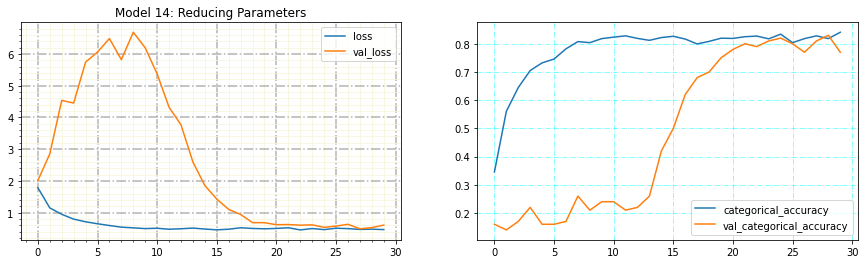

In [22]:
plot(history_model14,"Model 14: Reducing Parameters")

### Model 15 - reducing network parameters

In [23]:
class ModelConv3D15(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding = 'same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam(lr = 0.0002)
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [24]:
conv_3d15 = ModelConv3D15()
conv_3d15.initialize_path(project_folder)
conv_3d15.initialize_image_properties(image_height = 120, image_width = 120)
conv_3d15.initialize_hyperparams(frames_to_sample = 16, batch_size = 20, num_epochs = 25)
conv_3d15_model = conv_3d15.define_model(dense_neurons = 64, dropout = 0.25)
conv_3d15_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_26 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_21 (Activation)  (None, 8, 60, 60, 32)    

In [25]:
print("Total Params:", conv_3d15_model.count_params())
history_model15 = conv_3d15.train_model(conv_3d15_model, augment_data = True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7158 - categorical_accuracy: 0.3650
Epoch 00001: saving model to model_init/model_init_2022-11-1108_59_07.912954/model-00001-1.71582-0.36501-1.81581-0.21000.h5
34/34 [==============================] - 65s 2s/step - loss: 1.7158 - categorical_accuracy: 0.3650 - val_loss: 1.8158 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1608 - categorical_accuracy: 0.5535
Epoch 00002: saving model to model_init/model_init_2022-11-1108_59_07.912954/model-00002-1.16076-0.55354-2.23914-0.19000.h5
34/34 [==============================] - 62s 2s/step - loss: 1.1608 - categorical_accuracy: 0.5535 - val_loss: 2.2391 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
33/34 [============================>.] - ETA: 1s - loss: 0.9946 - categorical_accuracy: 0.6114
Epoch 00003: saving model to model_init/model_init_2022-11-1108_59_07.912

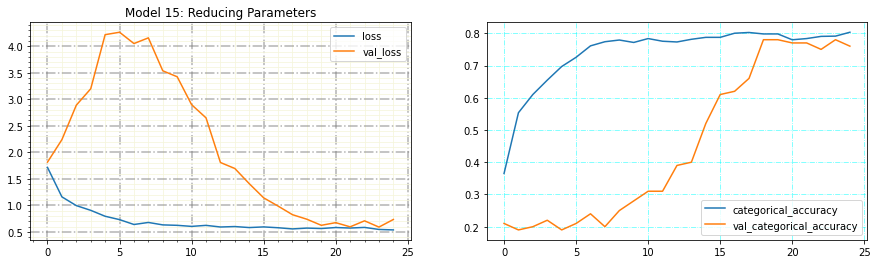

In [26]:
plot(history_model15, "Model 15: Reducing Parameters")

### Model 16 - reducing network parameters

In [27]:
class ModelConv3D16(ModelBuilderMoreAugmentation):
    
    def define_model(self, dense_neurons = 64, dropout = 0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding = 'same',
                 input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = tf.keras.optimizers.Adam(lr = 0.0002)
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [28]:
conv_3d16 = ModelConv3D16()
conv_3d16.initialize_path(project_folder)
conv_3d16.initialize_image_properties(image_height = 120, image_width = 120)
conv_3d16.initialize_hyperparams(frames_to_sample = 16, batch_size = 20, num_epochs = 30)
conv_3d16_model = conv_3d16.define_model(dense_neurons = 64, dropout = 0.25)
conv_3d16_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_32 (Bat  (None, 16, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_25 (Activation)  (None, 8, 60, 60, 16)    

In [29]:
print("Total Params:", conv_3d16_model.count_params())
history_model16 = conv_3d16.train_model(conv_3d16_model, augment_data = True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.0268 - categorical_accuracy: 0.3077
Epoch 00001: saving model to model_init/model_init_2022-11-1109_25_25.647261/model-00001-2.02680-0.30769-1.85261-0.16000.h5
34/34 [==============================] - 64s 2s/step - loss: 2.0268 - categorical_accuracy: 0.3077 - val_loss: 1.8526 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4641 - categorical_accuracy: 0.4412
Epoch 00002: saving model to model_init/model_init_2022-11-1109_25_25.647261/model-00002-1.46410-0.44118-2.34956-0.19000.h5
34/34 [==============================] - 63s 2s/step - loss: 1.4641 - categorical_accuracy: 0.4412 - val_loss: 2.3496 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2845 - categorical_accuracy: 0.5106
Epoch 00003: saving model to model_init/model_init_2022-11-1109_25_25.647

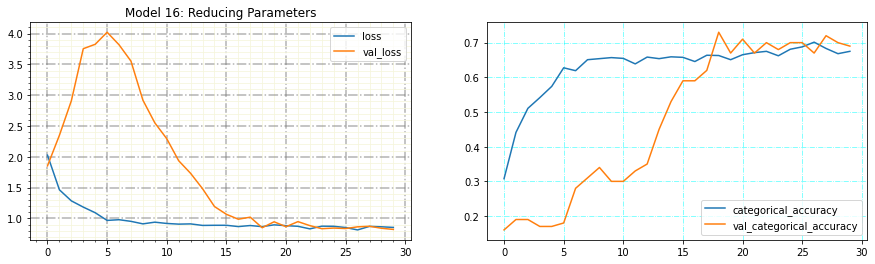

In [30]:
plot(history_model16, "Model 16: Reducing Parameters")

### Model 17 - CNN LSTM with GRU

In [33]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self, lstm_cells = 64, dense_neurons = 64, dropout = 0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding = 'same', activation = 'relu'),
                                  input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding = 'same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding = 'same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding = 'same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation = 'softmax'))
        optimiser = tf.keras.optimizers.Adam(lr = 0.0002)
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [34]:
rnn_cnn2 = RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height = 120, image_width = 120)
rnn_cnn2.initialize_hyperparams(frames_to_sample = 18, batch_size = 20, num_epochs = 20)
rnn_cnn2_model = rnn_cnn2.define_model(lstm_cells = 128, dense_neurons = 128, dropout = 0.25)
rnn_cnn2_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 60, 60, 32)  

In [35]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17 = rnn_cnn2.train_model(rnn_cnn2_model, augment_data = True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4520 - categorical_accuracy: 0.3861
Epoch 00001: saving model to model_init/model_init_2022-11-1109_57_50.630999/model-00001-1.45195-0.38612-1.66049-0.27000.h5
34/34 [==============================] - 74s 2s/step - loss: 1.4520 - categorical_accuracy: 0.3861 - val_loss: 1.6605 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9891 - categorical_accuracy: 0.6146
Epoch 00002: saving model to model_init/model_init_2022-11-1109_57_50.630999/model-00002-0.98915-0.61463-1.82432-0.27000.h5
34/34 [==============================] - 71s 2s/step - loss: 0.9891 - categorical_accuracy: 0.6146 - val_loss: 1.8243 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7670 - categorical_accuracy: 0.7059
Epoch 00003: saving model to model_init/model_init_2022-11-1109_57_50.63

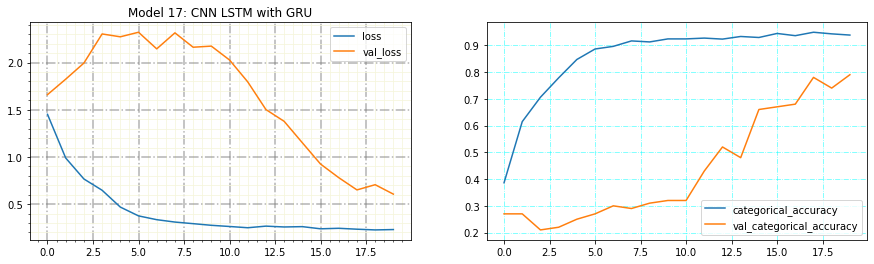

In [36]:
plot(history_model17, "Model 17: CNN LSTM with GRU")

### Model 18 - Transfer Learning

In [37]:
from keras.applications import mobilenet

In [38]:
mobilenet_transfer = mobilenet.MobileNet(weights = 'imagenet', include_top = False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self, lstm_cells = 64, dense_neurons = 64, dropout = 0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer, input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation = 'softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 2s 0us/step


In [39]:
rnn_cnn_tl = RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height = 120, image_width = 120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample = 16, batch_size = 5, num_epochs = 20)
rnn_cnn_tl_model = rnn_cnn_tl.define_model(lstm_cells = 128, dense_neurons = 128, dropout = 0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)              

In [40]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18 = rnn_cnn_tl.train_model(rnn_cnn_tl_model, augment_data = True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2211 - categorical_accuracy: 0.5106
Epoch 00001: saving model to model_init/model_init_2022-11-1110_21_35.078653/model-00001-1.22114-0.51056-0.78299-0.73000.h5
133/133 [==============================] - 68s 493ms/step - loss: 1.2211 - categorical_accuracy: 0.5106 - val_loss: 0.7830 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6792 - categorical_accuracy: 0.7602
Epoch 00002: saving model to model_init/model_init_2022-11-1110_21_35.078653/model-00002-0.67921-0.76018-0.66380-0.76000.h5
133/133 [==============================] - 64s 485ms/step - loss: 0.6792 - categorical_accuracy: 0.7602 - val_loss: 0.6638 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4389 - categorical_accuracy: 0.8333
Epoch 00003: saving model to model_init/model_init_2022-11-1110_

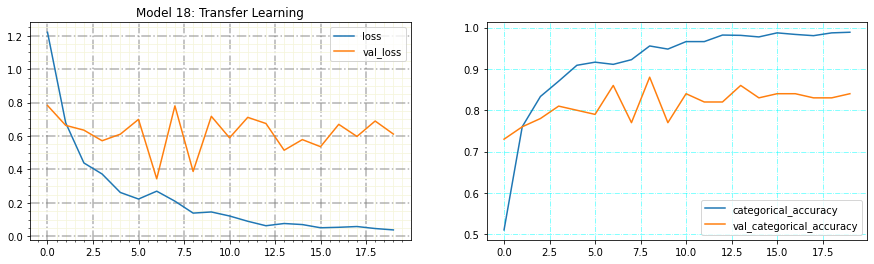

In [41]:
plot(history_model18, "Model 18: Transfer Learning")

## Model 19 - Transfer Learning with GRU and training all weights

In [17]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights = 'imagenet', include_top = False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self, gru_cells = 64, dense_neurons = 64, dropout = 0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer, input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation = 'relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation = 'softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model

In [18]:
rnn_cnn_tl2 = RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height = 120, image_width = 120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample = 16, batch_size = 5, num_epochs = 20)
rnn_cnn_tl2_model = rnn_cnn_tl2.define_model(gru_cells = 128, dense_neurons = 128, dropout = 0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               4

In [19]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19 = rnn_cnn_tl2.train_model(rnn_cnn_tl2_model, augment_data = True)

Total Params: 3693253
Epoch 1/20


2022-11-11 12:12:05.822989: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


133/133 [==============================] - ETA: 0s - loss: 0.8911 - categorical_accuracy: 0.6757
Epoch 00001: saving model to model_init/model_init_2022-11-1112_12_00.484924/model-00001-0.89106-0.67572-0.45480-0.84000.h5
133/133 [==============================] - 74s 512ms/step - loss: 0.8911 - categorical_accuracy: 0.6757 - val_loss: 0.4548 - val_categorical_accuracy: 0.8400 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.3624 - categorical_accuracy: 0.8778
Epoch 00002: saving model to model_init/model_init_2022-11-1112_12_00.484924/model-00002-0.36239-0.87783-0.53758-0.84000.h5
133/133 [==============================] - 67s 507ms/step - loss: 0.3624 - categorical_accuracy: 0.8778 - val_loss: 0.5376 - val_categorical_accuracy: 0.8400 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.2936 - categorical_accuracy: 0.9042
Epoch 00003: saving model to model_init/model_init_2022-11-1112_12_00.484924/model-00003-0.29360-

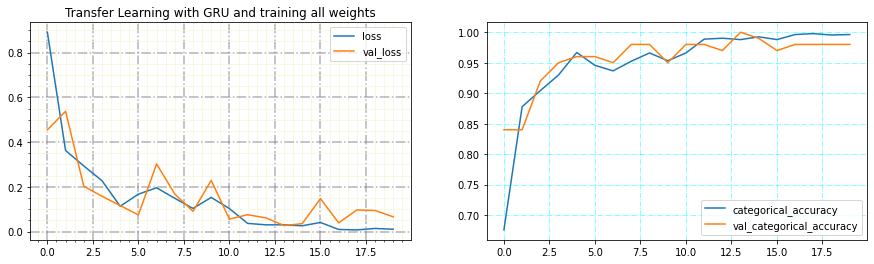

In [20]:
plot(history_model19, "Transfer Learning with GRU and training all weights")

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.